In [4]:
library(GUniFrac)

### Simulation

In [5]:
file_paths <- c("~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/ecam_10245/ecam_otu_table.tsv",
                "~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/pd_10483_otu_table.tsv")

In [6]:
list_of_dfs <- lapply(file_paths, function(file) read.table(file, sep = '\t', header=TRUE, row.names=1))


In [7]:
names(list_of_dfs) <- c("ecam", "pd")


In [8]:
#sample_size=list(length(rownames(list_of_dfs$ecam)),length(rownames(list_of_dfs$pd)))
sample_size=list(1000,1200)

In [9]:
sample_size[[2]]

[1] 1200

In [10]:
nsample=list(length(list_of_dfs$ecam),length(list_of_dfs$pd))

In [11]:
nsample[[2]]

[1] 410

In [15]:
num_dfs <- length(list_of_dfs)
num_sizes <- length(sample_size)
simulation <- vector("list", num_dfs)

for(i in 1:length(list_of_dfs)) {
    simulation[[i]] <- vector("list", num_sizes)
    for(j in 1:length(sample_size)){
    simulation[[i]][[j]] <- SimulateMSeq(
ref.otu.tab = list_of_dfs[[i]], nSam = 200, nOTU = sample_size[[j]],
# True signal setting
diff.otu.pct = 0.1, diff.otu.direct = c("unbalanced"), 
diff.otu.mode = c("abundant"),
covariate.type = c("binary"), grp.ratio = 1,
covariate.eff.mean = 1.0, covariate.eff.sd = 0,
# Confounder signal setting
confounder.type = c("both"), conf.cov.cor = 0.6,
conf.diff.otu.pct = 0.1, conf.nondiff.otu.pct = 0.1,
confounder.eff.mean = 1.0, confounder.eff.sd = 0,
# Depth setting
depth.mu = 10000, depth.theta = 5, depth.conf.factor = 0
)
 }   
}


Iteration 1: Log-likelihood value: -12958604.7384067

Iteration 2: Log-likelihood value: -12936632.967925

Iteration 3: Log-likelihood value: -12916488.3009465

Iteration 4: Log-likelihood value: -12898298.5036623

Iteration 5: Log-likelihood value: -12882182.0803318

Iteration 6: Log-likelihood value: -12868353.5488289

Iteration 7: Log-likelihood value: -12857134.5282301

Iteration 8: Log-likelihood value: -12848860.6662821

Iteration 9: Log-likelihood value: -12843624.477581

Iteration 10: Log-likelihood value: -12841004.4186788

Iteration 11: Log-likelihood value: -12840101.0531563

Iteration 12: Log-likelihood value: -12839934.2027679

Iteration 13: Log-likelihood value: -12839924.0579665

Iteration 14: Log-likelihood value: -12839923.9869446

Iteration 15: Log-likelihood value: -12839923.986939

Iteration 1: Log-likelihood value: -12958604.7384067

Iteration 2: Log-likelihood value: -12936632.967925

Iteration 3: Log-likelihood value: -12916488.3009465

Iteration 4: Log-likelihoo

In [17]:
#simulation


### Method run

In [18]:
run_method<- function(raw_data, DA_method){

  if(DA_method=="ANCOM-BC"){
    out<- run_ancombc(raw_data = raw_data)
  } else if(DA_method=="FlashWeave"){
    out<- run_flashweave(raw_data = raw_data)
  
  }

  return(out)
}


run_flashweave<- function(raw_data){

    setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
    # data file paths
    original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
    simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
    biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
    output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
    metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
    output_flash <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/flashnet1.qza'
    neighbour='/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/neighbours1.qza'
    exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours'
    
    meta.dat <- data.frame(X = raw_data$covariate, Z1 = raw_data$confounder[, 1],
                       Z2 = raw_data$confounder[, 2])
    otu.tab.sim <- raw_data$otu.tab.sim
    actual=ifelse(raw_data$diff.otu.ind, "DA", "NOT_DA")
    tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
     meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
    #otu data processing for qiime2 input
    otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:length(colnames(otu.tab.sim))])
    colnames(otu)[1] <- "featureid"
    rownames(otu) <- NULL

    write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
    #metadata processing for qiime2 input
    colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

    metad  <- cbind(rownames(meta.dat),meta.dat)
    colnames(metad)[1] <- "sampleid"
    rownames(metad) <- NULL
    write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

   # convert data into biom format
    system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)

    #import data into qiime 
    system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)
  
    # Run FlashWeave with sampled parameters
    system(paste("qiime makarsa flashweave",
             "--i-table", output_qza,
             "--m-metadata-file",metadata,
             "--p-heterogeneous", TRUE,         #need to replace parameters with their best 
             "--p-sensitive", TRUE,             #value found in hyperparameter tuning.
             "--p-max-k", 0,
             "--p-alpha", 0.05 ,
             "--o-network", output_flash), intern=TRUE)                              
  
 
 
    system(paste("qiime makarsa list-neighbours",
                "--i-network",output_flash,
                "--p-feature-id", "covariate",
                "--o-neighbours",neighbour), intern=TRUE)                 

   # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",neighbour,
             "--output-path",exported), intern=TRUE)                
  
  
  
  # Construct file path for metadata.tsv
   metadata_tsv <- paste0(exported, "/metadata.tsv")
  
  # Check if the file exists before reading
  if (!file.exists(metadata_tsv)) {
    cat("Expected metadata.tsv does not exist at path:", metadata_tsv, "\n")
    next
  }
  
  # Read the results
  neighbours <-read.csv(file = metadata_tsv, sep = '\t', row.names = 1)
  
  # take only necessary data
    neighbours=  neighbours[-1,] 
    e=rownames(otu.tab.sim)%in%rownames(neighbours)   
    pred=data.frame("pred" =ifelse(e, "DA", "NOT_DA") , row.names =rownames(otu.tab.sim) , stringsAsFactors = F)
    out_df=cbind(pred,tr) 
    
  # Return a list with the output of the method and the running time:
  return("method_out"=out_df)
}



run_ancombc<- function(raw_data){

    
    setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
    # data file paths
    original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
    simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
    biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
    output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
    metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
    ancomoutput <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/ancombc.qza'
    exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_ancompd'
    
    meta.dat <- data.frame(X = raw_data$covariate, Z1 = raw_data$confounder[, 1],
                       Z2 = raw_data$confounder[, 2])
    otu.tab.sim <- raw_data$otu.tab.sim
    actual=ifelse(raw_data$diff.otu.ind, "DA", "NOT_DA")
    tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
    meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
    #otu data processing for qiime2 input
    otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:length(colnames(otu.tab.sim))])
    colnames(otu)[1] <- "featureid"
    rownames(otu) <- NULL

    write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
    #metadata processing for qiime2 input
    colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

    metad  <- cbind(rownames(meta.dat),meta.dat)
    colnames(metad)[1] <- "sampleid"
    rownames(metad) <- NULL
    write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

   # convert data into biom format
    system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)
    #import data into qiime2                
    system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)
                   
   # Run ANCOM-BC with sampled parameters
    system(paste("qiime composition ancombc",
             "--i-table",output_qza,
             "--m-metadata-file", metadata,
             "--p-formula", "covariate",
             "--p-p-adj-method", "holm",
            # "--p-zero-cut", 0.7,
             "--p-lib-cut", 50,
            # "--p-struct-zero", FALSE,
             "--p-neg-lb", FALSE,
             "--p-tol", 1e-04,
             "--p-max-iter", 50,
             "--p-conserve", TRUE,
             "--p-alpha", 0.03,
            # "--p-global", TRUE,
             "--o-differentials", ancomoutput))                
  
   # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",ancomoutput,
             "--output-path",exported))                
  
  # Construct file path for q_val_slice.csv
   q_val_csv <- paste0(exported, "/q_val_slice.csv")
  
  # Check if the file exists before reading
  if (!file.exists(q_val_csv)) {
    cat("Expected q_val_slice.csv does not exist at path:", q_val_csv, "\n")
    next
  }
  
    # Read the q-value results
    ancom_q_val <- read.csv(file = q_val_csv, sep = ',', row.names = 1)

    # take only necessary data
    ancom_q_val=data.frame("covariateunhealthy" = ancom_q_val$covariateunhealthy, row.names = rownames(ancom_q_val), stringsAsFactors = F)
    #construct output dataframe
    e=!(rownames(otu.tab.sim)%in%rownames(ancom_q_val))
    nq=rownames(otu.tab.sim)[e]
    nqv=data.frame("covariateunhealthy" = rep(NA, length(nq)), row.names = nq, stringsAsFactors = F)
    q_val_all=rbind(ancom_q_val,nqv)
    names(q_val_all)[names(q_val_all) == "covariateunhealthy"] <- "q_value"
    pred= ifelse(ancom_q_val < 0.05, "DA", "NOT_DA")
    pred=as.data.frame(pred)
    d=!(rownames(otu.tab.sim)%in%rownames(pred))
    npred=rownames(otu.tab.sim)[d]
    ND=data.frame("covariateunhealthy" = rep("NOT_DA", length(npred)), row.names = npred, stringsAsFactors = F)
    pr=rbind(pred,ND)
    out_df=cbind(pr,q_val_all,tr)
    names(out_df)[names(out_df) == "covariateunhealthy"] <- "pred"

  return("method_out"=out_df)
}



### Running methods on simulated data

In [19]:
# List of methods you want to run
methods_to_run <- c("ANCOM-BC", "FlashWeave")  # Add more if needed

# Initialize results_list
results_list <- list()
for(method in methods_to_run) {
  results_list[[method]] <- vector("list", length(list_of_dfs))
  for(i in 1:length(list_of_dfs)) {
    results_list[[method]][[i]] <- vector("list", length(sample_size))
  }
}

# Loop over datasets and methods
for(i in 1:length(list_of_dfs)) {
  for(j in 1:length(sample_size)) {
    data <- simulation[[i]][[j]]
    
    for(method in methods_to_run) {
      # Run the method
      result <- run_method(data, method)
      
      # Store the result
      results_list[[method]][[i]][[j]] <- result
    }
  }
}


In [20]:
results_list

,pred,q_value,truth
,<chr>,<dbl>,<chr>
4347159,NOT_DA,1.00000000,NOT_DA
4454839,NOT_DA,1.00000000,NOT_DA
4448331,NOT_DA,1.00000000,NOT_DA
4476604,NOT_DA,1.00000000,NOT_DA
4468234,NOT_DA,1.00000000,DA
73000,NOT_DA,1.00000000,DA
4476527,NOT_DA,1.00000000,DA
145801,NOT_DA,1.00000000,NOT_DA
4344883,NOT_DA,0.21481147,DA


### RUNNING OUTPUT TO GENERATE PR-RECALL DATAFRAME

In [21]:
# Compute Precision and Recall
# param:
#   - truth: a vector that contains the labels that identify the simulated otu as "DA" or "NOT_DA".
#   - pred: a vector that contains the predicted labels.
# return: a named vector with precision and recall

compute_precision_recall<- function(truth, pred){

  if(all(is.na(pred))){
    out<- c(NA,NA)
    names(out)<- c("recall", "precision")
    return(out)
  }

  # Reassign the labels. The positive class is the one with the lowest number, i.e. "DA":
  truth<- ifelse(truth == "DA", 1, 0)
  pred<- ifelse(pred == "DA", 1, 0)

  # Compute the number of False Positive (FP), False Negative (FN), True Positive (TP), True Negative (TN):
  FP<- sum(truth==0 & pred==1)
  FN<- sum(truth==1 & pred==0)
  TP<- sum(truth==1 & pred==1)
  TN<- sum(truth==0 & pred==0)

  # Calculate Precision and Recall:
  if(TP==0 & FP==0){
    precision<- NA
  }else{
    precision<- TP/(TP+FP)
  }

  if(TP==0 & FN==0){
    recall<- NA
  }else{
    recall<- TP/(TP+FN)
  }

  if(FP==0 & TN==0){
    fpr<- NA
  }else{
    fpr<- FP/(FP+TN)
  }

  f1_score<- 2*(recall*precision)/(precision+recall)

  # Return precision and recall:
  out<- c(recall,precision,fpr, f1_score)
  names(out)<- c("recall", "precision","fpr", "f1_score")
  return(out)
}


In [22]:
# Initialize a dataframe to store precision-recall metrics
precision_recall_df <- data.frame()

for(method in methods_to_run) {
    recall_vector <- c()
    precision_vector <- c()
    fpr_vector <- c()
    f1_vector <- c()
    
    for(i in 1:length(list_of_dfs)) {
        for(j in 1:length(sample_size)) {
            method_results <- results_list[[method]][[i]][[j]]
            
            prec_rec_out <- compute_precision_recall(truth = method_results$truth, pred = method_results$pred)
            
            recall_vector <- c(recall_vector, prec_rec_out["recall"])
            precision_vector <- c(precision_vector, prec_rec_out["precision"])
            fpr_vector <- c(fpr_vector, prec_rec_out["fpr"])
            f1_vector <- c(f1_vector, prec_rec_out["f1_score"])
        }
    }
    
    tmp_df <- data.frame("method" = rep(method, length(recall_vector)),
                         "recall" = recall_vector,
                         "precision" = precision_vector,
                         "fpr" = fpr_vector,
                         "F1" = f1_vector,
                         "na_precision" = rep(sum(is.na(precision_vector)), length(recall_vector)),
                         stringsAsFactors = F)
    
    precision_recall_df <- rbind(precision_recall_df, tmp_df)
}


In [23]:
precision_recall_df

method,recall,precision,fpr,F1,na_precision
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ANCOM-BC,0.03000000,0.3000000,0.007777778,0.05454545,0
ANCOM-BC,0.10833333,0.5909091,0.008333333,0.18309859,0
ANCOM-BC,0.04000000,0.3636364,0.007777778,0.07207207,0
ANCOM-BC,0.02500000,0.3750000,0.004629630,0.04687500,0
FlashWeave,0.04000000,0.8000000,0.001111111,0.07619048,0
FlashWeave,0.06666667,0.4444444,0.009259259,0.11594203,0
FlashWeave,0.13000000,0.6842105,0.006666667,0.21848739,0
FlashWeave,0.10000000,0.7058824,0.004629630,0.17518248,0


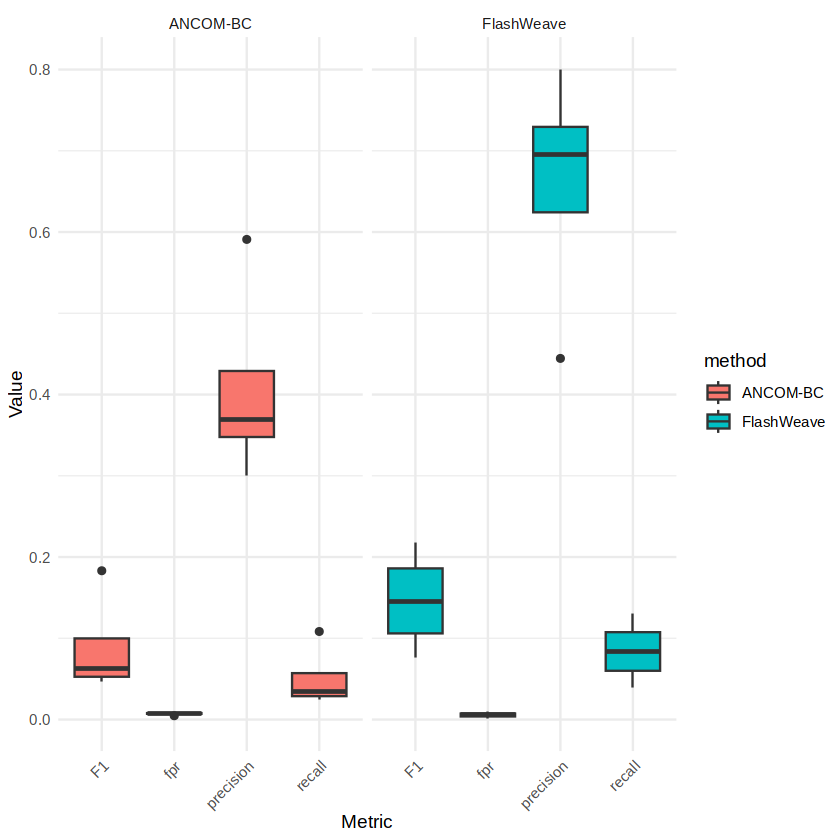

In [24]:
# Load the necessary libraries
library(ggplot2)
library(tidyr)

# Assuming your data.frame is named 'df'
df <- precision_recall_df

# Convert the data to a long format for easier plotting with ggplot2
df_long <- pivot_longer(df, cols = -c(method, na_precision), names_to = "metric", values_to = "value")

# Create a boxplot
ggplot(df_long, aes(x = metric, y = value, fill = method)) +
  geom_boxplot() +
  facet_wrap(~ method) + # Faceting by method to compare them side by side
  theme_minimal() +
  labs(y = "Value", x = "Metric") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis labels if needed


In [ ]:
compute_pr_curve<- function(method_list, sim_list, assgin_NOTDA_to_one_cond_zero = T){
  results<- list()
  for (i_method in names(method_list)) {
    pr_list<- list()
    for (i_sim in names(sim_list)) {
      sim_output<- sim_list[[i_sim]]
      method_output<- method_list[[i_method]][[paste0(i_sim, "_", i_method)]]
      if(is.data.frame(method_output$method_out)){
        pr_curve<- compute_curve(method_output = method_output, sim_output = sim_output, assgin_NOTDA_to_one_cond_zero = assgin_NOTDA_to_one_cond_zero)
        pr_list[[i_sim]]<- pr_curve
      } else{
        warning(paste("Error in running", i_method, "on", i_sim, ". This simulation is not considered by the metric."))
      }
    }
    results[[i_method]][["pr_list"]]<- pr_list
    results[[i_method]][["pr_mean"]]<- compute_mean_curve(pr_list = pr_list)
  }
  return(results)
}
compute_curve<- function(method_output, sim_output, assgin_NOTDA_to_one_cond_zero = T){

  metrics_df<- create_classification_df(method_output, sim_output, assgin_NOTDA_to_one_cond_zero = assgin_NOTDA_to_one_cond_zero)

  metrics_df<- metrics_df[order(metrics_df$score, decreasing = F), ]

  pred<- rep("NOT_DA", nrow(metrics_df))
  prec_rec_out<- c()
  for (i in 1:nrow(metrics_df)) {
    pred[i]<- "DA"
    prec_rec_out<- rbind(prec_rec_out, compute_precision_recall(truth = metrics_df$truth, pred = pred)[c("recall", "precision")])
  }
  prec_rec_out<- cbind(prec_rec_out, metrics_df$score)
  colnames(prec_rec_out)<- c("recall", "precision", "score")
  prec_rec_out<- as.data.frame(prec_rec_out)
  AUPR<- pracma::trapz(prec_rec_out$recall, prec_rec_out$precision)
  pprec_rec_out<- prec_rec_out[prec_rec_out$precision>=0.9,]
  pAUPR<- pracma::trapz(pprec_rec_out$recall, pprec_rec_out$precision)

  return(list("pr_curve"=prec_rec_out, "AUPR"=AUPR, "pAUPR"=pAUPR))

}

compute_mean_curve<- function(pr_list){
  recall_df<- c()
  precision_df<- c()
  AUPR<- c()
  pAUPR<- c()
  for (i in 1:length(pr_list)) {
    recall_df<- cbind(recall_df, pr_list[[i]][["pr_curve"]][["recall"]])
    precision_df<- cbind(precision_df, pr_list[[i]][["pr_curve"]][["precision"]])
    AUPR<- c(AUPR, pr_list[[i]][["AUPR"]])
    pAUPR<- c(pAUPR, pr_list[[i]][["pAUPR"]])
  }
  mean_curve<- data.frame("recall" = apply(recall_df, MARGIN = 1, FUN = mean), "precision" = apply(precision_df, MARGIN = 1, FUN = mean))
  mean_aupr<- mean(AUPR)
  sd_aupr<- stats::sd(AUPR)
  mean_paupr<- mean(pAUPR)
  sd_paupr<- stats::sd(AUPR)

  return(list("pr_curve"=mean_curve, "AUPR"=data.frame("mean_aupr"=mean_aupr, "sd_aupr"=sd_aupr), "pAUPR"=data.frame("mean_paupr"=mean_paupr, "sd_paupr"=sd_paupr)))
}



In [ ]:
compute_curve<- function(method_output, sim_output, assgin_NOTDA_to_one_cond_zero = T){

  metrics_df<- create_classification_df(method_output, sim_output, assgin_NOTDA_to_one_cond_zero = assgin_NOTDA_to_one_cond_zero)

  metrics_df<- metrics_df[order(metrics_df$score, decreasing = F), ]

  pred<- rep("NOT_DA", nrow(metrics_df))
  prec_rec_out<- c()
  for (i in 1:nrow(metrics_df)) {
    pred[i]<- "DA"
    prec_rec_out<- rbind(prec_rec_out, compute_precision_recall(truth = metrics_df$truth, pred = pred)[c("recall", "precision")])
  }
  prec_rec_out<- cbind(prec_rec_out, metrics_df$score)
  colnames(prec_rec_out)<- c("recall", "precision", "score")
  prec_rec_out<- as.data.frame(prec_rec_out)
  AUPR<- pracma::trapz(prec_rec_out$recall, prec_rec_out$precision)
  pprec_rec_out<- prec_rec_out[prec_rec_out$precision>=0.9,]
  pAUPR<- pracma::trapz(pprec_rec_out$recall, pprec_rec_out$precision)

  return(list("pr_curve"=prec_rec_out, "AUPR"=AUPR, "pAUPR"=pAUPR))

}



In [ ]:
compute_mean_curve<- function(pr_list){
  recall_df<- c()
  precision_df<- c()
  AUPR<- c()
  pAUPR<- c()
  for (i in 1:length(pr_list)) {
    recall_df<- cbind(recall_df, pr_list[[i]][["pr_curve"]][["recall"]])
    precision_df<- cbind(precision_df, pr_list[[i]][["pr_curve"]][["precision"]])
    AUPR<- c(AUPR, pr_list[[i]][["AUPR"]])
    pAUPR<- c(pAUPR, pr_list[[i]][["pAUPR"]])
  }
  mean_curve<- data.frame("recall" = apply(recall_df, MARGIN = 1, FUN = mean), "precision" = apply(precision_df, MARGIN = 1, FUN = mean))
  mean_aupr<- mean(AUPR)
  sd_aupr<- stats::sd(AUPR)
  mean_paupr<- mean(pAUPR)
  sd_paupr<- stats::sd(AUPR)

  return(list("pr_curve"=mean_curve, "AUPR"=data.frame("mean_aupr"=mean_aupr, "sd_aupr"=sd_aupr), "pAUPR"=data.frame("mean_paupr"=mean_paupr, "sd_paupr"=sd_paupr)))
}



In [10]:
library(pracma)

# Assume you have a dataframe called pr_curve with columns recall and precision
pr_curve <- data.frame(
  recall = c(1, 0.8, 0.6, 0.4, 0.2, 0),
  precision = c(1, 0.9, 0.8, 0.7, 0.4, 0)
)

# Calculate the AUPR
AUPR <- trapz(pr_curve$recall, pr_curve$precision)

# Print the AUPR
print(AUPR)


[1] -0.66


In [31]:
precision_recall_df

method,recall,precision,fpr,F1,na_precision
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ANCOM-BC,0.03000000,0.3000000,0.007777778,0.05454545,0
ANCOM-BC,0.10833333,0.5909091,0.008333333,0.18309859,0
ANCOM-BC,0.04000000,0.3636364,0.007777778,0.07207207,0
ANCOM-BC,0.02500000,0.3750000,0.004629630,0.04687500,0
FlashWeave,0.04000000,0.8000000,0.001111111,0.07619048,0
FlashWeave,0.06666667,0.4444444,0.009259259,0.11594203,0
FlashWeave,0.13000000,0.6842105,0.006666667,0.21848739,0
FlashWeave,0.10000000,0.7058824,0.004629630,0.17518248,0


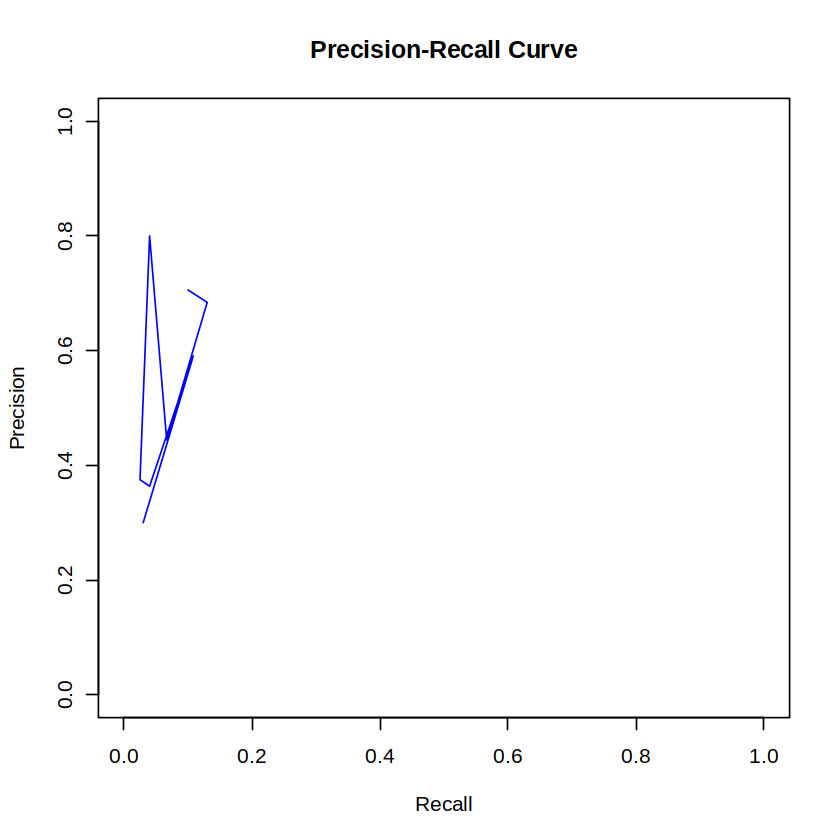

In [32]:
library(PRROC)

# Assuming `scores` are the classifier's probability scores or any continuous output
# `labels` are the true binary labels of the data (0 or 1)
scores <- c(0.9, 0.8, 0.3, 0.2)
labels <- c(1, 1, 0, 0)

# Calculate the precision-recall curve values
pr <- pr.curve(scores.class0 = scores, weights.class0 = labels)

# Extract the precision-recall values
pr_curve <- data.frame(recall = precision_recall_df$recall, precision = precision_recall_df$precision)

# Plot the precision-recall curve
plot(pr_curve$recall, pr_curve$precision, type = "l", col = "blue",
     xlab = "Recall", ylab = "Precision", main = "Precision-Recall Curve", xlim = c(0, 1), ylim = c(0, 1))


In [3]:
install.packages("PRROC")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [34]:
compute_pr_curve <- function(results_df) {
  # Initialize the list to store PR curves
  pr_list <- list()
  
  # Iterate over the unique methods in the results dataframe
  for (method in unique(results_df$method)) {
    # Filter the results for the current method
    method_results <- results_df[results_df$method == method, ]
    
    # Order the results by score
    #method_results <- method_results[order(method_results$score, decreasing = TRUE), ]
    
    # Initialize vectors to store precision and recall
    recall_vector <- c()
    precision_vector <- c()
    
    # Initialize predictions to all NOT_DA
    pred <- rep("NOT_DA", nrow(method_results))
    
    # Calculate precision and recall at each threshold
    for (i in 1:nrow(method_results)) {
      pred[i] <- "DA"
      truth <- ifelse(method_results$truth == "DA", 1, 0)
      pred_binary <- ifelse(pred == "DA", 1, 0)
      tp <- sum(truth == 1 & pred_binary == 1)
      fp <- sum(truth == 0 & pred_binary == 1)
      fn <- sum(truth == 1 & pred_binary == 0)
      
      precision <- ifelse((tp + fp) > 0, tp / (tp + fp), 1)
      recall <- ifelse((tp + fn) > 0, tp / (tp + fn), 1)
      
      recall_vector <- c(recall_vector, recall)
      precision_vector <- c(precision_vector, precision)
    }
    
    # Store the PR curve for the current method
    pr_curve <- data.frame("recall" = recall_vector, "precision" = precision_vector)
    AUPR <- pracma::trapz(pr_curve$recall, pr_curve$precision)
    
    # Store the results in the list
    pr_list[[method]] <- list("pr_curve" = pr_curve, "AUPR" = AUPR)
  }
  
  return(pr_list)
}

# Assume results_df is your dataframe with columns: method, truth, score, and possibly other metrics
pr_results <- compute_pr_curve(precision_recall_df)

In [35]:
pr_results

recall,precision
<dbl>,<dbl>
1,1
1,1
1,1
1,1
recall,precision
<dbl>,<dbl>
1,1
1,1
1,1


In [9]:
library(ANCOMBC)
#?ancombc2
#?ancombc 
#?ancom
?secom_linear
#?secom_dist